# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.332465
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 
Since the weight matrix W is uniformly and randomly selected, the prediction probability of each category is uniformly distributed, and the number of categories in the program is 10, so the probability of each category is equal to 1/10. Therefore, the cross entropy for each example is -log(0.1), which should equal the loss.



In [27]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.750485 analytic: 3.750485, relative error: 2.101198e-09
numerical: -2.511664 analytic: -2.511664, relative error: 3.661209e-08
numerical: -0.846448 analytic: -0.846448, relative error: 1.305037e-09
numerical: 0.902847 analytic: 0.902847, relative error: 4.094399e-08
numerical: -0.250860 analytic: -0.250860, relative error: 1.540374e-07
numerical: 1.827793 analytic: 1.827793, relative error: 2.274405e-08
numerical: 0.077805 analytic: 0.077805, relative error: 7.518700e-07
numerical: -1.309413 analytic: -1.309413, relative error: 6.437518e-09
numerical: -2.372522 analytic: -2.372522, relative error: 1.266315e-08
numerical: -0.416075 analytic: -0.416075, relative error: 9.701463e-09
numerical: 0.020243 analytic: 0.020866, relative error: 1.516608e-02
numerical: 1.789242 analytic: 1.788248, relative error: 2.779729e-04
numerical: 0.196946 analytic: 0.198500, relative error: 3.931063e-03
numerical: -2.004325 analytic: -2.007384, relative error: 7.624890e-04
numerical: 1.160916 

In [28]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.332465e+00 computed in 0.294764s
vectorized loss: 2.332465e+00 computed in 0.040481s
Loss difference: 0.000000
Gradient difference: 0.000000


In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = np.linspace(1e-7, 5e-7, 5)
# regularization_strengths = np.linspace(2.5e4, 5e4, 6)

learning_rates = [1e-7, 2e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]
regularization_strengths =[(1+0.1*i)*1e4 for i in range(-3,4)] + [(5+0.1*i)*1e4 for i in range(-3,4)]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass


for rate in learning_rates:
    for reg_now in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=rate, reg=reg_now, num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(rate, reg_now)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 224.758567
iteration 100 / 2000: loss 193.543809
iteration 200 / 2000: loss 168.116221
iteration 300 / 2000: loss 145.844825
iteration 400 / 2000: loss 126.691457
iteration 500 / 2000: loss 110.388079
iteration 600 / 2000: loss 95.892160
iteration 700 / 2000: loss 83.364218
iteration 800 / 2000: loss 72.698930
iteration 900 / 2000: loss 63.369099
iteration 1000 / 2000: loss 55.314957
iteration 1100 / 2000: loss 48.272414
iteration 1200 / 2000: loss 42.056545
iteration 1300 / 2000: loss 36.834915
iteration 1400 / 2000: loss 32.172189
iteration 1500 / 2000: loss 28.223498
iteration 1600 / 2000: loss 24.871112
iteration 1700 / 2000: loss 21.662703
iteration 1800 / 2000: loss 19.119709
iteration 1900 / 2000: loss 16.856831
iteration 0 / 2000: loss 252.871652
iteration 100 / 2000: loss 213.587048
iteration 200 / 2000: loss 181.589354
iteration 300 / 2000: loss 154.643175
iteration 400 / 2000: loss 132.097728
iteration 500 / 2000: loss 112.461593
iteration 600 / 2000

iteration 0 / 2000: loss 1585.233964
iteration 100 / 2000: loss 568.825864
iteration 200 / 2000: loss 205.479614
iteration 300 / 2000: loss 75.102088
iteration 400 / 2000: loss 28.298605
iteration 500 / 2000: loss 11.576839
iteration 600 / 2000: loss 5.553262
iteration 700 / 2000: loss 3.351923
iteration 800 / 2000: loss 2.611138
iteration 900 / 2000: loss 2.324876
iteration 1000 / 2000: loss 2.271758
iteration 1100 / 2000: loss 2.203569
iteration 1200 / 2000: loss 2.217786
iteration 1300 / 2000: loss 2.215550
iteration 1400 / 2000: loss 2.202872
iteration 1500 / 2000: loss 2.139921
iteration 1600 / 2000: loss 2.146641
iteration 1700 / 2000: loss 2.222759
iteration 1800 / 2000: loss 2.192116
iteration 1900 / 2000: loss 2.186526
iteration 0 / 2000: loss 1620.646407
iteration 100 / 2000: loss 570.696060
iteration 200 / 2000: loss 202.023803
iteration 300 / 2000: loss 72.419363
iteration 400 / 2000: loss 26.894677
iteration 500 / 2000: loss 10.881265
iteration 600 / 2000: loss 5.183559
it

iteration 200 / 2000: loss 32.986545
iteration 300 / 2000: loss 6.650958
iteration 400 / 2000: loss 2.735520
iteration 500 / 2000: loss 2.229189
iteration 600 / 2000: loss 2.167832
iteration 700 / 2000: loss 2.245018
iteration 800 / 2000: loss 2.202636
iteration 900 / 2000: loss 2.172936
iteration 1000 / 2000: loss 2.168218
iteration 1100 / 2000: loss 2.203133
iteration 1200 / 2000: loss 2.188295
iteration 1300 / 2000: loss 2.146845
iteration 1400 / 2000: loss 2.126178
iteration 1500 / 2000: loss 2.134275
iteration 1600 / 2000: loss 2.148131
iteration 1700 / 2000: loss 2.196751
iteration 1800 / 2000: loss 2.160344
iteration 1900 / 2000: loss 2.197771
iteration 0 / 2000: loss 1502.717799
iteration 100 / 2000: loss 210.157464
iteration 200 / 2000: loss 31.012698
iteration 300 / 2000: loss 6.199250
iteration 400 / 2000: loss 2.712277
iteration 500 / 2000: loss 2.225577
iteration 600 / 2000: loss 2.188515
iteration 700 / 2000: loss 2.218117
iteration 800 / 2000: loss 2.139851
iteration 900

iteration 600 / 2000: loss 2.303974
iteration 700 / 2000: loss 2.151614
iteration 800 / 2000: loss 2.019536
iteration 900 / 2000: loss 2.016366
iteration 1000 / 2000: loss 2.100566
iteration 1100 / 2000: loss 2.060689
iteration 1200 / 2000: loss 2.078402
iteration 1300 / 2000: loss 2.051447
iteration 1400 / 2000: loss 2.022960
iteration 1500 / 2000: loss 2.026798
iteration 1600 / 2000: loss 2.088028
iteration 1700 / 2000: loss 2.043891
iteration 1800 / 2000: loss 2.085139
iteration 1900 / 2000: loss 2.063008
iteration 0 / 2000: loss 397.213730
iteration 100 / 2000: loss 107.825931
iteration 200 / 2000: loss 30.419817
iteration 300 / 2000: loss 9.742950
iteration 400 / 2000: loss 4.041024
iteration 500 / 2000: loss 2.664767
iteration 600 / 2000: loss 2.256698
iteration 700 / 2000: loss 2.107412
iteration 800 / 2000: loss 2.116427
iteration 900 / 2000: loss 1.989867
iteration 1000 / 2000: loss 2.040491
iteration 1100 / 2000: loss 2.013450
iteration 1200 / 2000: loss 2.041163
iteration 13

In [45]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.373000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ *True.*


$\color{blue}{\textit Your Explanation:}$
The softmax classifier is the minimum loss value. For the correct classification, the higher the probability is always obtained. The error classification always gets a lower possibility, so that the loss value is smaller. However, the SVM is different, as long as the loss value reaches zero, it will not improve the accuracy of the correct classification.


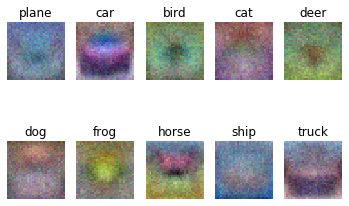

In [46]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])